In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [115]:
# code adapted from ChatGPT

# Define your neural network model
class Q_learning_NN(nn.Module):
    def __init__(self):
        super(Q_learning_NN, self).__init__()

        self.step1 = nn.Linear(3, 128, bias=True)
        self.step2 = nn.ReLU()
        self.step3 = nn.Linear(128, 64, bias=True)
        self.step4 = nn.ReLU()
        self.step5 = nn.Linear(64, 16, bias=True)
        self.step6 = nn.ReLU()
        self.step7 = nn.Linear(16, 4, bias=True)

        # multi-class classification adapted from ChatGPT
        self.step8 = nn.Softmax(dim=1)

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.step5(x)
        x = self.step6(x)
        x = self.step7(x)
        x = self.step8(x)
        
        return x

def train_model(inputs, desired_outputs, num_epochs=100, learning_rate=0.01, viz_accuracy=False):
    # Convert inputs and desired_outputs to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
    
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Initialize the model
    model = Q_learning_NN()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Mean Squared Error loss
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []

    inputs = inputs.float()
    desired_outputs = desired_outputs.long()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass

            batch_desired_outputs = batch_desired_outputs.long()

            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item
        
        # Print the average loss for this epoch
        scheduler.step()
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

    # Return the trained model
    return model

In [116]:
df = pd.read_csv("learned_Q_moves.csv")

In [117]:
just_input = df.drop('last_matrix', axis=1)
just_input = just_input.drop('first_move_by_Q_learning', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = np.array(just_input.values.tolist())

In [118]:
desired_output = torch.tensor(df['first_move_by_Q_learning'].tolist(), dtype=torch.float32).long()

C:\Users\16089\AppData\Local\Temp\ipykernel_6020\792525016.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)


total loss: 8.222243785858154
Epoch [1/500], Loss: 1.3704
total loss: 8.109561085700989
Epoch [2/500], Loss: 1.3516
total loss: 8.013470888137817
Epoch [3/500], Loss: 1.3356
total loss: 7.904801726341248
Epoch [4/500], Loss: 1.3175
total loss: 7.801074266433716
Epoch [5/500], Loss: 1.3002
total loss: 7.704849004745483
Epoch [6/500], Loss: 1.2841
total loss: 7.613754391670227
Epoch [7/500], Loss: 1.2690
total loss: 7.524716734886169
Epoch [8/500], Loss: 1.2541
total loss: 7.4390928745269775
Epoch [9/500], Loss: 1.2398
total loss: 7.361868977546692
Epoch [10/500], Loss: 1.2270
total loss: 7.310269355773926
Epoch [11/500], Loss: 1.2184
total loss: 7.252678394317627
Epoch [12/500], Loss: 1.2088
total loss: 7.205384731292725
Epoch [13/500], Loss: 1.2009
total loss: 7.1778810024261475
Epoch [14/500], Loss: 1.1963
total loss: 7.1374019384384155
Epoch [15/500], Loss: 1.1896
total loss: 7.107445955276489
Epoch [16/500], Loss: 1.1846
total loss: 7.068612456321716
Epoch [17/500], Loss: 1.1781
tot

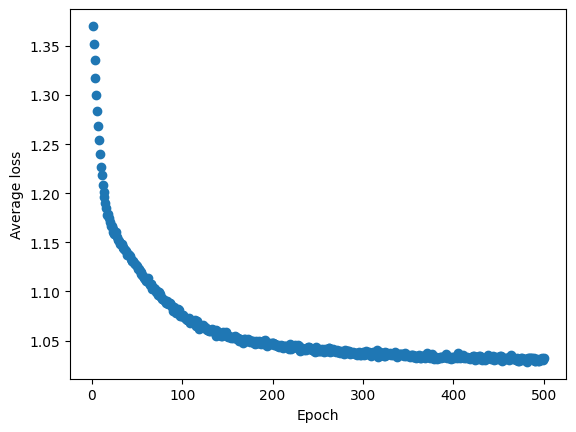

In [119]:
# Train the model
trained_model = train_model(input_data, desired_output, 500, learning_rate=0.0005, viz_accuracy=True)

In [120]:
def test_model(trained_model, new_data, expected_result):
    test_input = torch.tensor(new_data, dtype=torch.float32)

    test_output = trained_model(test_input)

    predicted_classes = torch.argmax(test_output, dim=1)

    test_output_compare = torch.tensor(expected_result, dtype=torch.int)

    return float(sum(test_output_compare == predicted_classes)/len(test_input))

In [121]:
test_df = pd.read_csv("learned_Q_moves_test.csv")
just_input_test = test_df.drop('first_move_by_Q_learning', axis=1)
just_input_test = just_input_test.drop('last_matrix', axis=1)

input_data_test = np.array(just_input_test.values.tolist())
desired_output = torch.tensor(test_df['first_move_by_Q_learning'].tolist(), dtype=torch.float32).long()

In [122]:
# can get 70% accuracy. Got 66% accuracy when doing Q learning with default values of the score of that state.
# 63% accuracy when using discount_factor=0.99.
# Downside of using lower discount factors is that we learn how to get to the origin for less of the dataset.
# Using discount_factor=0.8 means we only learn 90% of the dataset. Using 0.99 meant we learned 99%.  
test_model(trained_model, input_data_test, desired_output)

C:\Users\16089\AppData\Local\Temp\ipykernel_6020\875939923.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.70062655210495

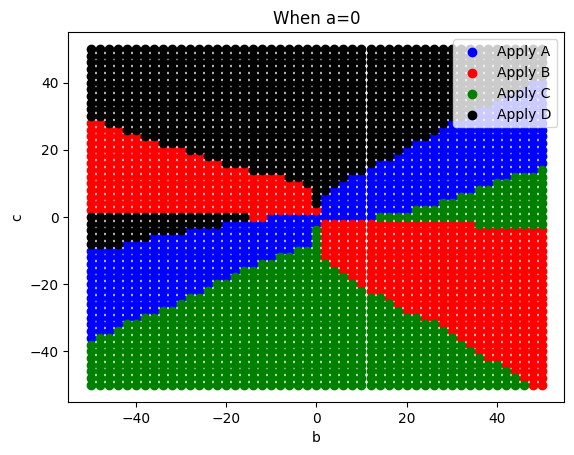

In [123]:
# plot a vizualization of what we would predict for a bunch of ordered pairs

confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-50, 51, 2):
    for j in range(-50, 51, 2):
        demo_test_type = torch.tensor([[0, i, j]], dtype=torch.float32)
        confidence = int(torch.argmax(trained_model(demo_test_type)))
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("b")
plt.ylabel("c")
plt.title("When a=0")
plt.legend()
plt.show()

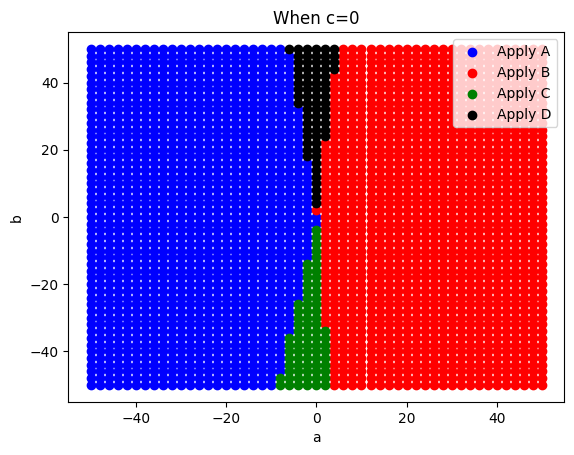

In [124]:
confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-50, 51, 2):
    for j in range(-50, 51, 2):
        demo_test_type = torch.tensor([[i, 0, j]], dtype=torch.float32)
        confidence = int(torch.argmax(trained_model(demo_test_type)))
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("a")
plt.ylabel("b")
plt.title("When c=0")
plt.legend()
plt.show()

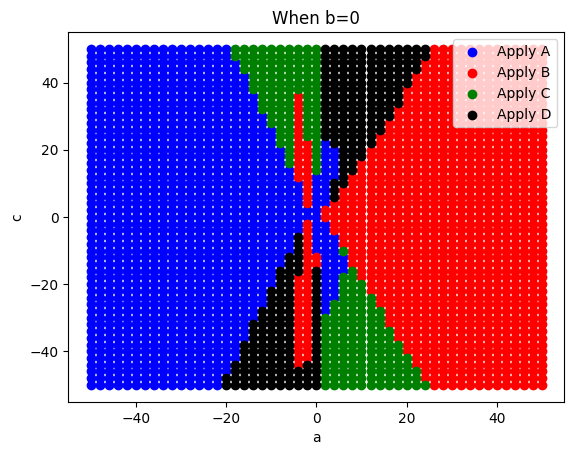

In [125]:
confidence_df = pd.DataFrame({
    'x': [],
    'y': [],
    'confidence': []
})

for i in range(-50, 51, 2):
    for j in range(-50, 51, 2):
        demo_test_type = torch.tensor([[i, j, 0]], dtype=torch.float32)
        confidence = int(torch.argmax(trained_model(demo_test_type)))
        df2 = pd.DataFrame([[i, j, confidence]], columns=['x', 'y', 'confidence'])
        confidence_df = pd.concat([confidence_df, df2])
c0 = confidence_df[confidence_df['confidence']==0]
c1 = confidence_df[confidence_df['confidence']==1]
c2 = confidence_df[confidence_df['confidence']==2]
c3 = confidence_df[confidence_df['confidence']==3]

plt.scatter(c0['x'], c0['y'], c="blue", label="Apply A")
plt.scatter(c1['x'], c1['y'], c="red", label="Apply B")
plt.scatter(c2['x'], c2['y'], c="green", label="Apply C")
plt.scatter(c3['x'], c3['y'], c="black", label="Apply D")

# where [[1, a, c], [0, 1, b], [0, 0, 1]]
plt.xlabel("a")
plt.ylabel("c")
plt.title("When b=0")
plt.legend()
plt.show()

In [134]:
# B is the inverse of A
A = np.array([[1, 1, 0], [0, 1, 0], [0, 0, 1]])
B = np.array([[1, -1, 0], [0, 1, 0], [0, 0, 1]])

# C is the inverse of D
C = np.array([[1, 0, 0], [0, 1, 1], [0, 0, 1]])
D = np.array([[1, 0, 0], [0, 1, -1], [0, 0, 1]])

In [148]:
# how long does it take us to get back to the origin? 
def matrix_to_tuple(matrix):
    return (matrix[0][1], matrix[0][2], matrix[1][2])

def num_steps_to_origin_w_nn(test_mat):
    for i in range(100):

        if (test_mat==A).all() or (test_mat==B).all() or (test_mat==C).all() or (test_mat==D).all():
            return i
        demo_test_type = torch.tensor([matrix_to_tuple(test_mat)], dtype=torch.float32)
        action = int(torch.argmax(trained_model(demo_test_type)))

        if action==0:
            test_mat = test_mat @ A
        elif action==1:
            test_mat = test_mat @ B
        elif action==2:
            test_mat = test_mat @ C
        else:
            test_mat = test_mat @ D

    return 1000

In [155]:
test_mat = np.array([[1, 20, 0], [0, 1, 0], [0, 0, 1]])
num_steps_to_origin_w_nn(test_mat)

19